# Avito: O que é? 

# Importando libs

In [1]:
%matplotlib inline  
import numpy as np
import pandas as pd
import scipy as sp

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Carregando o dataset

In [2]:
df_simple = pd.read_csv('train.csv.zip', compression='zip')

## Tratamento dos dados

In [3]:
# transformando descrições nulas em str vazias
df_simple['description'] = df_simple['description'].replace(np.nan, '', regex=True)


In [64]:

# trocando para que colunas com valores em russo sejam substituidas por valores de 0-N
# acho q isso vai facilitar na hora de acessar essas colunas
# ao inves de tentar pegar pelos diferentes valores de cada uma
def convert_columns_with_russian_values_to_numbers(df, cols):
    transform_dict = {}
    for col in cols:
        cats = pd.Categorical(df[col]).categories
        d = {}
        for i, cat in enumerate(cats):
            d[cat] = f'{i}'
        transform_dict[col] = d
    inverse_transform_dict = {}
    for col, d in transform_dict.items():
        inverse_transform_dict[col] = {v:k for k, v in d.items()}
        
    return df.replace(transform_dict), transform_dict, inverse_transform_dict
# Aplica essa função para category_name e region
df, transform_dict, inverse_transform_dict = convert_columns_with_russian_values_to_numbers(df_simple, ['category_name', 'region'])

# transforma user_type e category_name em diferentes colunas com representações one-hot delas
df = pd.get_dummies(df, columns=['user_type','category_name', ])


In [65]:
transform_dict

{'category_name': {'Автомобили': '0',
  'Аквариум': '1',
  'Аудио и видео': '2',
  'Билеты и путешествия': '3',
  'Бытовая техника': '4',
  'Велосипеды': '5',
  'Водный транспорт': '6',
  'Гаражи и машиноместа': '7',
  'Готовый бизнес': '8',
  'Грузовики и спецтехника': '9',
  'Детская одежда и обувь': '10',
  'Дома, дачи, коттеджи': '11',
  'Другие животные': '12',
  'Земельные участки': '13',
  'Игры, приставки и программы': '14',
  'Квартиры': '15',
  'Книги и журналы': '16',
  'Коллекционирование': '17',
  'Коммерческая недвижимость': '18',
  'Комнаты': '19',
  'Кошки': '20',
  'Красота и здоровье': '21',
  'Мебель и интерьер': '22',
  'Мотоциклы и мототехника': '23',
  'Музыкальные инструменты': '24',
  'Настольные компьютеры': '25',
  'Недвижимость за рубежом': '26',
  'Ноутбуки': '27',
  'Оборудование для бизнеса': '28',
  'Одежда, обувь, аксессуары': '29',
  'Оргтехника и расходники': '30',
  'Охота и рыбалка': '31',
  'Планшеты и электронные книги': '32',
  'Посуда и товары дл

In [5]:
# add deal_prob_class (low, average ou high)

def convert_deal_probability_to_class(value):
    classes = [

    ]
    if value * 100 <= (100 / 3 * 1):
        return 'low'
    elif value * 100 <= (100 / 3 * 2):
        return 'average'
    else:
        return 'high'

df['deal_prob_class'] = df['deal_probability'].apply(convert_deal_probability_to_class)

### Bag of words creator

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def prepare_vectorizer_and_col(df, col_name):
    vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords.words('russian'))
    corpus = df[col_name]
    col_vectorized = vectorizer.fit_transform(corpus)
    return col_vectorized, vectorizer

    

from rake_nltk import Rake

def return_description_reduced(df):
    # Uses stopwords for russian from NLTK, and all puntuation characters.
    r = Rake(language='russian')
    
    total = df['description'].shape[0]
    
    verbose_step_size = int(total/10)
    description_reduced = []
    for i, description in enumerate(df['description']):
        r.extract_keywords_from_text(description)
        phrases_and_scores = r.get_ranked_phrases_with_scores()    
        mean_score = np.mean([x[0] for x in phrases_and_scores])

        highest_phrases = [x[1] for x in phrases_and_scores if x[0] >= mean_score]
        reduced_description = ' '.join(highest_phrases)
        description_reduced.append(reduced_description)
        
        
        if i % verbose_step_size == 0:
            print(f'{int(i/total*100)}') 
        
    return description_reduced



[nltk_data] Downloading package stopwords to /home/arruda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Para salvar e carregar os models

In [7]:
import pickle
def save_description_linear_regression_model(pkl_filename, model):
    with open(pkl_filename, 'wb') as f:
        pickle.dump(model, f)
def load_description_linear_regression_model(pkl_filename):
    with open(pkl_filename, 'rb') as f:
        pickle_model = pickle.load(f)
        return pickle_model

## Train-test split (com amostra)

In [8]:
# train_frac == 0.34 ~= 510000 ~= total de exemplos no test_csv.zip
def get_train_test_samples(df, seed, train_frac=0.34): 
    train_dfs = []
    test_dfs = []
    for klass in ['low', 'average', 'high']:
        klass_df = df[df['deal_prob_class'] == klass]
        klass_train, klass_test = train_test_split(klass_df,  test_size=(1-train_frac), random_state=seed)
        train_dfs.append(klass_train)
        test_dfs.append(klass_test)
        
    train_df = pd.concat(train_dfs, ignore_index=True)
    test_df = pd.concat(test_dfs, ignore_index=True)
    return train_df, test_df

seed = np.random.RandomState(seed=123654)
train_df, test_df = get_train_test_samples(df, seed, train_frac=0.34)

511163

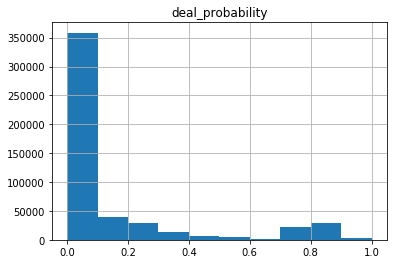

In [11]:
train_df.hist('deal_probability')
train_df.shape[0]

## criando description reduced

In [55]:
def load_description_reduced_from_csv(df, filename):
    try:
        description_df = pd.read_csv(filename, header=None, index_col=0, names=['description_reduced'])
        values = description_df['description_reduced'].values
    except:
        values = return_description_reduced(df)
    return values


In [ ]:
train_df['description_reduced'] = load_description_reduced_from_csv(train_df, 'train_df_description_reduced.csv')

In [ ]:
description_vectorized, vectorizer_description = prepare_vectorizer_and_col(train_df, 'description_reduced')

In [ ]:
test_df['description_reduced'] = load_description_reduced_from_csv(test_df, 'train_test_df_description_reduced.csv')

In [ ]:
description_vectorized_test = vectorizer_description.transform(test_df['description_reduced'])

## SVR na descrição reduzida

In [35]:
from sklearn.svm import SVR
try:
    description_reduced_countvec_svr_model = load_description_linear_regression_model(
        'description_reduced_countvec_svr_model.pkl')
except:
    description_reduced_countvec_svr_model = SVR(kernel='poly', verbose=True, cache_size=16000)     
    description_reduced_countvec_svr_model.fit(description_vectorized, train_df['deal_probability'])


In [27]:
# y_predic_train = description_reduced_countvec_svr_model.predict(description_vectorized)
try:
    y_predict_train = pd.read_csv(
        'y_predict_train_svr_desc_reduc.csv', header=0, index_col=0, names=['y_predict_model_svr_desc']).values
except:
#     y_predic_train = description_reduced_countvec_svr_model.predict(description_vectorized)
    pass

In [31]:

def limit_value(value):
    if value > 1:
        value = 1
    elif value < 0:
        value = 0
    return value
y_treated_train = np.array(list(map(limit_value, y_predict_train)))

In [32]:
# y_predict_train_df = pd.DataFrame(y_predic_train)
# y_predict_train_df.to_csv('y_predict_train_svr_desc_reduc.csv')

## SVR  nos campos numericos + saida do svr na descrição

In [37]:
train_df['price'] = train_df['price'].fillna(0.0)
test_df['price'] = test_df['price'].fillna(0.0)

train_df['y_predict_model_svr_desc'] = y_treated_train

desc = train_df.describe()
colums_name = list(desc.columns.values)
colums_name.pop(colums_name.index('image_top_1'))
colums_name.pop(colums_name.index('deal_probability'))
colums_name

['price',
 'item_seq_number',
 'user_type_Company',
 'user_type_Private',
 'user_type_Shop',
 'category_name_0',
 'category_name_1',
 'category_name_10',
 'category_name_11',
 'category_name_12',
 'category_name_13',
 'category_name_14',
 'category_name_15',
 'category_name_16',
 'category_name_17',
 'category_name_18',
 'category_name_19',
 'category_name_2',
 'category_name_20',
 'category_name_21',
 'category_name_22',
 'category_name_23',
 'category_name_24',
 'category_name_25',
 'category_name_26',
 'category_name_27',
 'category_name_28',
 'category_name_29',
 'category_name_3',
 'category_name_30',
 'category_name_31',
 'category_name_32',
 'category_name_33',
 'category_name_34',
 'category_name_35',
 'category_name_36',
 'category_name_37',
 'category_name_38',
 'category_name_39',
 'category_name_4',
 'category_name_40',
 'category_name_41',
 'category_name_42',
 'category_name_43',
 'category_name_44',
 'category_name_45',
 'category_name_46',
 'category_name_5',
 'category

In [38]:
numeric_fields_svr_model = SVR(kernel='poly', verbose=True, cache_size=4000)    

In [39]:
numeric_fields_svr_model.fit(train_df[colums_name], train_df['deal_probability'])

[LibSVM]

SVR(C=1.0, cache_size=4000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=True)

In [41]:
save_description_linear_regression_model('numeric_fields_and_predic_desc_svr_model.pkl', numeric_fields_svr_model)

In [28]:
print(mean_squared_error(test_df['deal_probability'], np.zeros(y_predic.shape)))
print(mean_squared_error(test_df['deal_probability'], y_treated))

0.08696623321357727
0.06911413911149261


# Running on test.csv for submission

In [61]:
submission_df = pd.read_csv('test.csv.zip', compression='zip')
submission_df['description'] = submission_df['description'].replace(np.nan, '', regex=True)

In [43]:
submission_df['description_reduced'] = return_description_reduced(submission_df)

0


/home/arruda/.virtualenvs/icd_final-cXF_SA4B/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/arruda/.virtualenvs/icd_final-cXF_SA4B/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


9
19
29
39
49
59
69
79
89
99


In [34]:
description_vectorized_submission = vectorizer_description.transform(submission_df['description_reduced'])

### linear regression

In [46]:
y_predic = desc_red_countvec_lreg_model.predict(description_vectorized_submission)

### svr

In [35]:
y_predic = description_reduced_countvec_svr_model.predict(description_vectorized_submission)

### svr numeric + svr desc reduced predict

In [49]:
# pega o valor já calculado anteriormente em outra submissão
y_predict_description_reduced_svr = pd.read_csv('submission_svr.csv', index_col='item_id')['deal_probability'].values

In [68]:

# Aplica essa função para category_name e region virarem numeros
submission_df = submission_df.replace(transform_dict)

# transforma user_type e category_name em diferentes colunas com representações one-hot delas
submission_df = pd.get_dummies(submission_df, columns=['user_type','category_name', ])


In [69]:
submission_df['price'] = submission_df['price'].fillna(0.0)

submission_df['y_predict_model_svr_desc'] = y_predict_description_reduced_svr

desc = submission_df.describe()
colums_name = list(desc.columns.values)
colums_name.pop(colums_name.index('image_top_1'))
colums_name.pop(colums_name.index('y_predict_model_svr_desc'))
colums_name.append('y_predict_model_svr_desc')
colums_name

['price',
 'item_seq_number',
 'user_type_Company',
 'user_type_Private',
 'user_type_Shop',
 'category_name_0',
 'category_name_1',
 'category_name_10',
 'category_name_11',
 'category_name_12',
 'category_name_13',
 'category_name_14',
 'category_name_15',
 'category_name_16',
 'category_name_17',
 'category_name_18',
 'category_name_19',
 'category_name_2',
 'category_name_20',
 'category_name_21',
 'category_name_22',
 'category_name_23',
 'category_name_24',
 'category_name_25',
 'category_name_26',
 'category_name_27',
 'category_name_28',
 'category_name_29',
 'category_name_3',
 'category_name_30',
 'category_name_31',
 'category_name_32',
 'category_name_33',
 'category_name_34',
 'category_name_35',
 'category_name_36',
 'category_name_37',
 'category_name_38',
 'category_name_39',
 'category_name_4',
 'category_name_40',
 'category_name_41',
 'category_name_42',
 'category_name_43',
 'category_name_44',
 'category_name_45',
 'category_name_46',
 'category_name_5',
 'category

In [70]:
y_predic_numeric_svr_and_desc_reduced_predict = numeric_fields_svr_model.predict(submission_df[colums_name])

### post-processing

In [88]:
def normalized_predict(y_predict):
    min_y_predict = min(y_predict)
    
    if min_y_predict < 0:
        neg_fix = (min_y_predict*-1)
        y_predict = y_predict + neg_fix
        
    max_y_predict = max(y_predict)
        
    return (y_predict-min_y_predict)/(max_y_predict-min_y_predict)

In [102]:
def limit_value(value):
    if value > 1:
        value = 1
    elif value < 0:
        value = 0
    return value
y_predic_numeric_svr_and_desc_reduced_predict_treated = np.array(
    list(map(limit_value, y_predic_numeric_svr_and_desc_reduced_predict)))


In [103]:
submission_prediction_df = pd.DataFrame(
    {'deal_probability': y_predic_numeric_svr_and_desc_reduced_predict_treated}, 
    index=submission_df['item_id'])

In [104]:
submission_prediction_df.head()

,deal_probability
item_id,
6544e41a8817,1
65b9484d670f,0
8bab230b2ecd,0
8e348601fefc,0
8bd2fe400b89,0


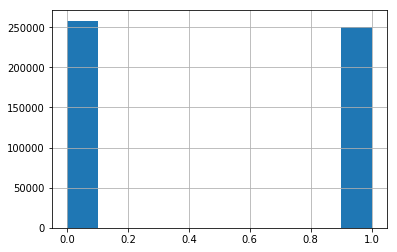

In [105]:
submission_prediction_df['deal_probability'].hist()

In [106]:
submission_prediction_df['deal_probability'].describe()

count    508438.000000
mean          0.492459
std           0.499944
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: deal_probability, dtype: float64

In [107]:
submission_prediction_df.to_csv('submission_svr_number_and_predict_svr_descr_reduc.csv')